## **Multi-armed bandit problem**

### Reinforcement learning

**MDP** - Markov Decision Processes

$\;s_t$ - current state\
$\;o_t$  - obesrvation made in $s_t$\
$\;a_t$ - decision made from state $s_t$

$\quad a_t \in \{0, 1, 2, ..., n\}$, where\
$\quad \quad n $= number of machines


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

import numpy as np
import random

from collections import namedtuple, deque

In [2]:
sys.path.append('..')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions) -> None:
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=0)
        return x

In [6]:
n_bandits = 6
model = DQN(1, n_bandits).to(device)

model(torch.tensor([1.0]))

tensor([0.1217, 0.1886, 0.1816, 0.1572, 0.1843, 0.1667],
       grad_fn=<SoftmaxBackward0>)

In [7]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_obersevations = 1
n_actions = n_bandits

In [8]:
model = DQN(n_obersevations, n_actions)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, amsgrad=True)
# memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return F.one_hot(torch.argmax(model(state)), n_actions)
    else:
        return F.one_hot(torch.randint(0, n_actions, (1,)), n_actions)

In [9]:
select_action(torch.tensor([1.0]))

tensor([[0, 0, 0, 1, 0, 0]])

### **Q-learning algorthitm**

In [32]:
from src.bandit import Bandit

In [51]:
iterations = 3000
episode_iterations = 2000
n_bandits = 10
exploration_prob = 1  # initial exploration probability
exploration_decay = 0.001
min_exploration_prob = 0.01
gamma = 0.99  # discount factor
lr = 0.1

q_table = np.zeros((n_bandits, 1))

bandits_probs = np.random.randint(20, 100, n_bandits) / 100
env = Bandit(bandits_probs)

In [52]:
total_rewards = []

In [53]:
def q_table_update_value(q_table, action, reward):
    return q_table[action] + lr * (reward - q_table[action])

for n in range(iterations):
    action = np.random.randint(n_bandits)

    total_episode_reward = 0

    for i in range(episode_iterations):
        
        if np.random.uniform(0, 1) < exploration_prob:
            action = np.random.randint(n_bandits)
        else:
            action = np.argmax(q_table)

        reward = env.pull(action)
        q_table[action] += q_table_update_value(q_table, action, reward)
        total_episode_reward += reward

    
    exploration_prob = max(min_exploration_prob, np.exp(-exploration_decay*n))
    total_rewards.append(total_episode_reward)

/tmp/ipykernel_4773/2058361475.py:17: RuntimeWarning: overflow encountered in add
  q_table[action] += q_table_update_value(q_table, action, reward)
/tmp/ipykernel_4773/2058361475.py:2: RuntimeWarning: invalid value encountered in add
  return q_table[action] + lr * (reward - q_table[action])


In [54]:
np.argmax(bandits_probs)

7

Text(0.5, 1.0, 'Total Reward vs Episode \n           number of bandits = 20, num of episodes = 2000')

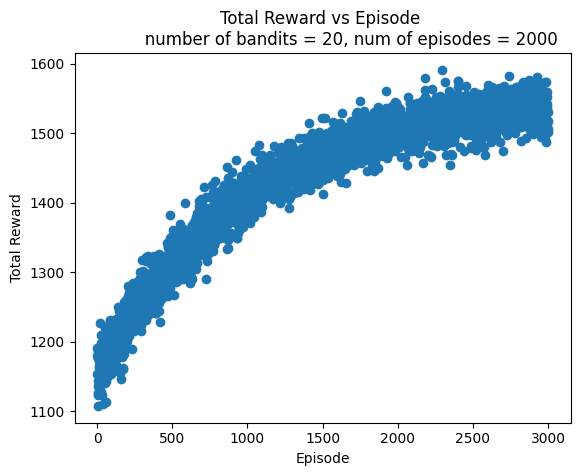

In [55]:
import matplotlib.pyplot as plt
plt.scatter(y=total_rewards, x=range(len(total_rewards)))
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f'Total Reward vs Episode \n\
           number of bandits = 20, num of episodes = {episode_iterations}')

Text(0, 0.5, 'Mean Reward')

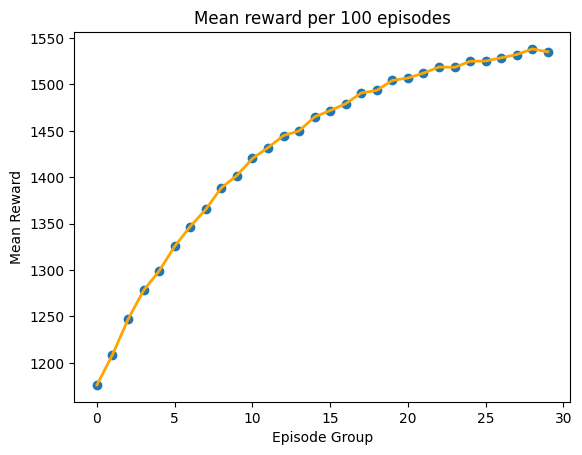

In [56]:
summary_seed = 100
summed_up_rewards = [np.mean(total_rewards[summary_seed*i:summary_seed*(i+1)])\
                      for i in range(iterations // summary_seed)]

plt.plot(summed_up_rewards, color='orange', linewidth=2)
plt.scatter(y=summed_up_rewards, x=range(len(summed_up_rewards)))
plt.title(f'Mean reward per {summary_seed} episodes')
plt.xlabel('Episode Group')
plt.ylabel('Mean Reward')